In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import inspect
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
from tensorboard import notebook
from model import Model
from sde_euler import sde_euler
from tf_sde_euler import tf_sde_euler
%load_ext tensorboard

import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=C:/Users/Harry/miniconda3/envs/tf/Library/bin"

np.random.seed(1)

Tensorflow version: 2.10.0


for training NN, remove OO approach and do it manually...

In [17]:
dt = 1e-3
N = 10
alpha = 1
sig = 1

# Set up random adjacency matrix
baseline = Model(N=10, dt=1e-3, alpha=1, sig=1)
obj = baseline
obj.erdosrenyi(0.5)
obj.network()
obj.simulate()

target_mat = obj.A
target_path = obj.x
print(target_mat)

[[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]]


In [13]:
# Training data parameters
time_window = 5
sample_size = 16 # to increase

# Neural network architecture parameters
num_input_nodes = 5*obj.N # time-window*N
num_output_nodes = obj.N**2

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='ReLU', input_shape=(num_input_nodes,), kernel_initializer=tf.keras.initializers.GlorotNormal),
    tf.keras.layers.Dense(20, activation='ReLU'),
    # tf.keras.layers.Dense(20, activation='ReLU'),
    # tf.keras.layers.Dense(20, activation='ReLU'),
    # tf.keras.layers.Dense(20, activation='ReLU'),
    tf.keras.layers.Dense(num_output_nodes, activation=tf.keras.activations.hard_sigmoid)
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 100)               2100      
                                                                 
Total params: 3,540
Trainable params: 3,540
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Hyper-parameters
epochs_per_episode = 10
batch_size = 50
lr = 1e-4

# Adam optimizer
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, amsgrad=True, jit_compile=True)

model.compile(
    optimizer,
    loss='mse'
)

In [67]:
A = tf.cast(tf.ones_like(obj.A), dtype=tf.float32)
A

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [68]:
@tf.function
def drift(x):
    return (alpha / N) * (tf.tensordot(A, x, axes=1) - x*tf.reduce_sum(A, axis=1))

@tf.function
def diffusion(x):
    return tf.cast(sig, dtype=tf.float32)

In [73]:
def simulate():

    # Shuffle target data and subsample to generate rolling windows
    idx = np.arange(sample_size)
    random.shuffle(idx)
    target_data = np.zeros((sample_size, time_window, obj.N))
    
    for i in np.arange(sample_size):
        target_data[i, :, :] = target_path[idx[i]:idx[i]+time_window]
    init_data = target_data[:, 0, :]

    # Simulate training data from initial data
    train_data = np.zeros((sample_size, time_window, obj.N))
    for i in np.arange(sample_size):
        train_data[i, :, :] = tf_sde_euler(drift, diffusion, (time_window-1)*dt, dt, tf.cast(init_data[i, :], dtype = tf.float32))

    return train_data, target_data

experiment with tf function

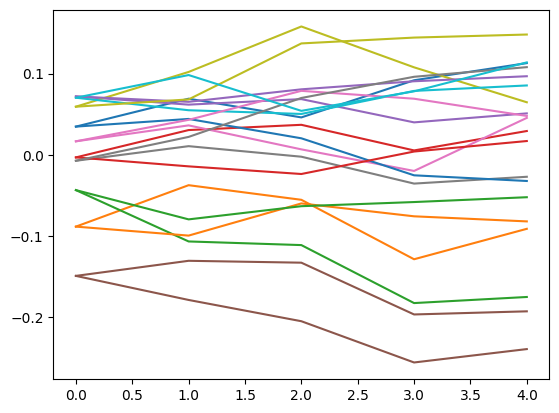

In [77]:
train_data, target_data = simulate()
plt.plot(train_data[1])
plt.plot(target_data[1])
plt.show()

# Training

In [81]:
#@tf.function(jit_compile=True)
def train_step(train_data, target_data):

    with tf.GradientTape() as tape:

        train_data_flat = np.reshape(train_data, [sample_size, num_input_nodes])
        target_data_flat = np.reshape(target_data, [sample_size, num_input_nodes])
        A = tf.reshape(tf.reduce_mean(model(train_data_flat, target_data_flat), axis=0), [obj.N, obj.N])
        
        # Forward pass of the model to get training paths
        new_train_data, new_target_data = simulate()

        # Compute batch loss value
        loss_value = mse(new_train_data, new_target_data) 

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)
    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value

In [82]:
train_step(train_data, target_data)

ValueError: No gradients provided for any variable: (['dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense/kernel:0' shape=(50, 20) dtype=float32, numpy=
array([[ 1.95653155e-01, -1.23863757e-01, -1.14324033e-01,
         1.21562511e-01, -1.87148303e-01,  2.44170919e-01,
        -2.60103852e-01,  7.33985528e-02, -3.00872028e-01,
         1.21362045e-01, -1.10243008e-01, -1.98852777e-01,
         2.88375556e-01,  1.47269875e-01,  8.04165602e-02,
        -2.62191594e-02, -1.81477025e-01,  1.14329793e-01,
         3.33795547e-01,  6.40506446e-02],
       [ 2.45733052e-01, -2.08774552e-01,  1.72817111e-01,
         6.00610785e-02,  6.76057637e-02, -2.35449150e-01,
         3.28882247e-01,  1.09859712e-01, -1.33129641e-01,
        -2.40353942e-01, -2.72942096e-01, -2.29498684e-01,
         9.53013375e-02,  6.11541159e-02, -3.57813269e-01,
         8.60306397e-02, -1.04017682e-01,  2.30470628e-01,
         7.57588223e-02, -1.08025447e-01],
       [-2.59747386e-01, -1.10624075e-01, -7.12528676e-02,
        -4.40664403e-02,  2.07709923e-01,  3.36742193e-01,
         3.05481046e-01,  9.74783748e-02, -1.45108804e-01,
        -6.33069277e-02, -1.27822280e-01,  1.66528657e-01,
         3.01372588e-01,  3.18427950e-01, -4.17776033e-02,
         1.34843349e-01, -1.14467040e-01, -1.70855105e-01,
         3.11888099e-01, -4.78329323e-03],
       [-2.19774082e-01,  2.18082536e-02, -3.18586379e-01,
        -1.59245491e-01,  7.57008046e-03, -7.89518505e-02,
         1.84376627e-01,  1.24469832e-01,  1.03775570e-02,
         1.47655413e-01, -1.63888440e-01,  2.23077089e-01,
        -4.16231863e-02,  3.48696798e-01, -1.05921462e-01,
        -4.42003459e-02, -3.10532182e-01, -6.93940073e-02,
         8.07401165e-03, -1.23004034e-01],
       [-2.54390329e-01, -1.31127372e-01, -1.10741153e-01,
         8.89125541e-02, -5.38009265e-03, -3.26478481e-01,
         1.24862127e-01,  7.12437555e-02,  2.68503368e-01,
         2.37398893e-01,  3.29105288e-01,  3.40273142e-01,
         3.16068754e-02, -5.51686026e-02, -7.00232834e-02,
         3.50436926e-01,  1.61924437e-02,  7.10408017e-03,
         1.74751610e-01,  1.83555067e-01],
       [ 1.62556991e-01,  1.59849077e-01, -2.01874170e-02,
        -4.62630764e-02, -2.45465264e-01, -2.64750849e-02,
        -3.59183103e-02, -4.70829122e-02,  2.79278427e-01,
        -1.58224210e-01, -1.05644166e-01, -1.57750592e-01,
         1.86036423e-01, -1.37590170e-01,  2.88111418e-02,
         3.60086113e-02,  2.06112713e-01, -1.49076059e-01,
         2.50536591e-01, -9.56819393e-03],
       [ 4.67138402e-02, -9.32193398e-02,  2.93120816e-02,
        -6.59683198e-02,  6.16455413e-02, -2.51706719e-01,
        -7.90635720e-02, -2.98455358e-02, -1.17618389e-01,
        -1.75421331e-02, -1.88160852e-01,  1.04097519e-02,
         8.07448477e-02, -1.24152370e-01,  1.34906977e-01,
        -1.22434072e-01,  3.45215917e-01, -4.15793285e-02,
        -1.62390068e-01, -2.67152309e-01],
       [-2.55146157e-02, -5.53192832e-02,  2.25805752e-02,
        -2.99524665e-02,  2.84270167e-01,  1.03983939e-01,
        -3.38997655e-02,  1.42760336e-01,  1.63716123e-01,
        -3.36723894e-01,  2.55120862e-02,  7.70320296e-02,
         6.24109618e-02, -1.06762826e-01,  3.47792238e-01,
        -8.81721377e-02, -3.60884041e-01, -2.04709768e-01,
         3.05740107e-02, -6.12406209e-02],
       [-5.66979051e-02,  1.06063329e-01, -2.71058768e-01,
        -1.03118479e-01,  1.10431187e-01, -1.18166208e-01,
        -1.64934680e-01, -3.61272871e-01,  2.27392346e-01,
         3.49838845e-02,  1.36957830e-02,  2.69581415e-02,
         2.86570974e-02, -2.11799741e-01, -6.06629886e-02,
        -9.00460109e-02,  5.54564297e-02,  2.22020894e-01,
        -2.11246684e-01,  1.60141230e-01],
       [ 1.74460188e-01, -2.02486575e-01,  7.97214359e-02,
        -1.08008228e-01,  2.30296806e-01,  7.22664520e-02,
         4.28647138e-02, -2.26790920e-01,  2.97137827e-01,
         1.90905511e-01,  2.06359401e-01, -1.07234888e-01,
        -1.61990955e-01, -1.84234723e-01, -1.70988590e-01,
         8.65072608e-02,  7.32252523e-02, -2.99525917e-01,
        -1.40464187e-01, -1.07231913e-02],
       [ 8.19190498e-03,  1.15686156e-01,  1.51660174e-01,
        -2.54872501e-01, -2.49192882e-02, -1.30234048e-01,
         2.30272666e-01, -2.16540545e-01,  1.87598675e-01,
        -1.12651862e-01, -8.29757098e-03,  8.08626637e-02,
        -7.39561394e-02,  7.47379735e-02, -1.95111975e-01,
         1.34832114e-01,  9.50793922e-02,  1.22682184e-01,
         2.07540706e-01, -1.54843658e-01],
       [-6.31089613e-04, -3.08852375e-01, -2.53175259e-01,
         1.04850575e-01,  1.35768456e-02, -1.84713844e-02,
         1.58060804e-01,  8.94487128e-02, -5.73603883e-02,
         3.69428813e-01, -2.05278993e-01, -9.96379480e-02,
        -6.89289905e-03,  2.41826307e-02, -3.00047636e-01,
        -9.34765339e-02,  8.52119327e-02,  1.81945041e-01,
         1.22367024e-01, -1.43087911e-03],
       [ 3.26770574e-01,  1.37136996e-01,  2.56526619e-02,
        -7.06842691e-02, -2.49712199e-01, -3.00083101e-01,
        -8.04780200e-02, -5.12335002e-02,  7.25447908e-02,
         4.45596362e-03,  1.31917903e-02, -2.02026181e-02,
         2.07310989e-01,  2.66857482e-02,  3.02402616e-01,
         1.52308404e-01, -3.16531748e-01,  1.84409648e-01,
         1.07753016e-01,  2.57211000e-01],
       [-1.79547697e-01,  7.31267780e-02, -2.35799998e-01,
        -1.82470068e-01, -1.64455280e-01, -2.31424958e-01,
         9.96595174e-02, -1.99301559e-02, -2.42649436e-01,
        -1.18922569e-01, -1.15596980e-01, -1.63468868e-01,
        -1.69586286e-01, -3.59496996e-02, -2.04126492e-01,
        -9.03982222e-02,  1.94724187e-01,  2.41803035e-01,
        -3.61113250e-01, -6.15924932e-02],
       [ 1.49244547e-01,  1.86783820e-01, -1.16635822e-01,
        -4.25502397e-02,  3.03126257e-02,  5.67256510e-02,
        -1.57199688e-02,  1.96518421e-01, -1.70891285e-01,
        -1.12559110e-01, -1.74070120e-01, -1.70407072e-02,
         1.87504947e-01,  1.86847653e-02, -2.51487702e-01,
         1.01591103e-01, -2.21148375e-02, -1.64009720e-01,
         3.58067416e-02,  6.97073042e-02],
       [-1.63576216e-01,  8.28671977e-02, -9.67110991e-02,
        -2.67188177e-02, -1.23530380e-01,  1.26445577e-01,
        -1.68031916e-01,  1.25598341e-01,  1.04515776e-01,
        -1.54289886e-01, -3.75137568e-01, -9.65857804e-02,
        -9.63326916e-02, -5.81217110e-02,  6.60391152e-02,
         4.89294268e-02, -2.95593720e-02,  1.78374261e-01,
         7.76139870e-02,  2.29540974e-01],
       [ 9.54899415e-02,  6.38227537e-02,  2.11995989e-01,
        -1.03140384e-01, -3.17358226e-01,  3.26816767e-01,
        -1.16290651e-01, -1.77918911e-01,  3.48768048e-02,
         1.60176069e-01,  2.58984361e-02, -3.10348481e-01,
        -1.59282923e-01,  2.03785330e-01, -3.49689014e-02,
         3.25693607e-01,  2.07730621e-01,  7.58979702e-03,
        -1.68711245e-01,  1.99034929e-01],
       [-1.50576591e-01, -1.67093530e-01,  5.71266226e-02,
        -5.86173730e-03,  2.72011250e-01,  2.95366555e-01,
        -6.39415532e-02,  2.21179917e-01,  3.11802208e-01,
         8.13673660e-02,  5.11198975e-02, -2.60285467e-01,
         6.79217428e-02, -2.64105052e-01, -3.68165858e-02,
         7.38079920e-02,  1.32597521e-01, -5.57649843e-02,
         2.51901507e-01, -2.89567500e-01],
       [ 1.86195955e-01,  2.99533635e-01,  1.91981435e-01,
        -8.55696574e-03, -6.96092993e-02,  1.44199759e-01,
        -2.54733682e-01, -3.27681839e-01,  8.25404823e-02,
         1.06667824e-01, -7.84077197e-02, -1.79213747e-01,
         2.88619548e-02,  2.66371757e-01,  3.94752016e-03,
        -3.40649903e-01,  2.07281578e-03,  6.53999997e-03,
         1.09123573e-01,  3.23008373e-02],
       [-1.27036840e-01, -1.68110147e-01, -4.67686169e-02,
         2.41390347e-01, -1.62000760e-01,  3.00356418e-01,
         2.90292948e-01, -1.58976287e-01,  2.72789989e-02,
         6.98570609e-02,  2.15094730e-01,  1.23735443e-01,
         1.56874701e-01,  3.30459088e-01,  5.93756884e-02,
        -1.92481242e-02, -1.38111919e-01, -4.04397678e-03,
         6.00647554e-02, -2.19318330e-01],
       [ 2.36940935e-01, -1.48802936e-01,  5.79051748e-02,
        -3.07970531e-02,  1.38611004e-01, -8.28042850e-02,
        -2.70519424e-02,  1.58575714e-01,  1.58197820e-01,
        -4.87289764e-02,  2.06333339e-01, -2.94299759e-02,
        -1.04137637e-01, -1.12951674e-01, -1.59528837e-01,
        -2.05764174e-01, -1.60570722e-02,  1.11246118e-02,
        -8.96549895e-02, -9.72139910e-02],
       [-9.45218280e-02,  1.39567107e-01, -1.86338931e-01,
         2.99831659e-01, -1.91113409e-02,  5.25697097e-02,
         1.56375334e-01, -1.88113168e-01, -2.45506898e-01,
         3.89760151e-03, -5.05137257e-02,  1.78732369e-02,
         1.33580402e-01,  2.24229455e-01, -2.39046931e-01,
         2.27724060e-01, -7.80163184e-02,  8.56305435e-02,
         4.80309725e-02, -3.33078176e-01],
       [-1.75237834e-01,  2.93804049e-01, -1.22270584e-01,
         8.35750997e-02,  1.14858672e-01, -1.05234832e-01,
        -1.30173519e-01, -3.89417112e-02,  1.00714199e-01,
         2.42619336e-01,  1.64160281e-01, -1.20510766e-03,
        -2.17184592e-02, -8.73612165e-02,  1.53002217e-01,
        -3.61024827e-01, -5.21852411e-02, -1.35549694e-01,
         2.32613808e-03,  2.10640550e-01],
       [-2.68871933e-02, -1.71020105e-01,  6.27811924e-02,
         7.03381076e-02, -8.75917673e-02,  2.04846147e-03,
         1.70847378e-03, -9.98480469e-02, -1.63309321e-01,
         1.40864581e-01, -2.96768043e-02,  3.84171098e-01,
         1.76862612e-01,  2.16351673e-01,  9.78688821e-02,
        -1.51586175e-01, -4.17313445e-03,  6.04268648e-02,
         1.40525207e-01, -8.40358287e-02],
       [-9.87458155e-02,  6.07836992e-03,  1.31550327e-01,
        -7.22608669e-03, -1.98068991e-01, -3.07905190e-02,
        -5.98066263e-02, -1.57145202e-01,  2.06362918e-01,
        -9.21745002e-02,  2.06314459e-01,  6.13904409e-02,
         1.71861559e-01, -1.45271808e-01,  4.59233113e-02,
        -1.20062701e-01,  4.42160405e-02, -1.51064456e-01,
        -1.61537006e-01, -7.75156394e-02],
       [-1.32185861e-01,  7.39089102e-02, -3.43528748e-01,
        -8.08024034e-02,  2.02604219e-01,  3.60087007e-01,
         1.40444487e-01, -1.50057167e-01, -7.95482658e-03,
        -2.22831339e-01,  3.42813939e-01,  9.02480185e-02,
         2.16948688e-02, -2.23340943e-01,  3.45879272e-02,
        -2.33178824e-01, -2.76706189e-01, -9.71397310e-02,
        -1.72560170e-01, -7.50746503e-02],
       [-2.22957302e-02, -8.17361027e-02, -1.33862868e-01,
         2.15336025e-01, -2.66776294e-01, -3.98770310e-02,
         1.82234004e-01, -8.89909789e-02, -7.71149015e-03,
         1.27865821e-01, -1.44811034e-01,  1.49740666e-01,
        -4.82471958e-02,  2.57981986e-01,  7.42207021e-02,
         1.32354051e-02, -5.08221500e-02,  1.60143420e-01,
        -3.28868181e-02, -3.53440851e-01],
       [-2.25525331e-02, -1.62352622e-01,  1.97561800e-01,
         7.31576681e-02,  2.09115669e-01, -5.57154752e-02,
         3.69853415e-02,  3.46022427e-01, -2.06396818e-01,
        -8.30123425e-02, -2.23403707e-01,  2.55077690e-01,
        -2.35458121e-01, -2.18680143e-01, -1.37553602e-01,
         3.45845222e-01,  1.13366775e-01,  1.03760228e-01,
         5.52788675e-02, -4.40091267e-02],
       [-1.77694634e-01, -2.81306505e-01, -3.05724815e-02,
         2.01193720e-01,  1.06611505e-01, -2.72599724e-03,
        -1.28673941e-01,  4.79772761e-02,  2.72223532e-01,
        -9.28848237e-02, -1.20866664e-01,  5.03057241e-02,
         1.28514916e-01,  2.06145868e-01,  1.49184003e-01,
        -3.09088286e-02,  1.04625441e-01,  2.20703602e-01,
         1.55244753e-01,  2.58550197e-01],
       [-2.13488657e-02, -1.14598714e-01,  3.25856417e-01,
        -2.27989227e-01, -2.73155361e-01,  1.21361040e-01,
        -2.84486264e-01, -3.60823929e-01,  1.39236376e-01,
        -1.35914460e-01, -1.47834480e-01, -3.29853475e-01,
        -3.60115170e-01, -3.45827609e-01, -1.10108638e-02,
         3.15978527e-01, -1.70561492e-01,  2.24665865e-01,
         2.26962827e-02, -1.13915965e-01],
       [ 9.98448506e-02,  9.13967788e-02,  5.59580438e-02,
         7.13532120e-02, -2.52929777e-01, -2.68505700e-02,
        -1.44929409e-01,  8.63021985e-02,  2.04128161e-01,
         9.99873132e-02, -1.22277871e-01, -1.24938644e-01,
        -4.95309159e-02,  1.77781954e-01, -3.77851501e-02,
        -1.49432331e-01, -1.17714137e-01, -9.27549899e-02,
        -1.30978981e-02,  1.28276020e-01],
       [ 1.89072728e-01,  2.89323758e-02,  2.86840409e-01,
         7.39669129e-02,  9.61792395e-02, -4.50298227e-02,
        -2.37742186e-01,  1.65046766e-01, -2.16505826e-02,
        -2.38431796e-01,  1.84630558e-01, -3.45239013e-01,
        -1.63321406e-01,  1.82553723e-01, -2.78289795e-01,
         1.07687153e-02, -1.59257650e-01, -1.93079039e-01,
         1.33678675e-01, -1.55603513e-01],
       [ 1.54019013e-01, -2.09406778e-01, -3.38116229e-01,
         1.51017621e-01, -6.35087118e-02, -1.03117369e-01,
         1.24866135e-01, -2.93561488e-01,  2.63509005e-01,
         3.59018892e-01,  3.17898780e-01,  1.40942469e-01,
        -2.55599022e-01, -2.31708270e-02, -2.88448602e-01,
         2.18209073e-01,  8.08296576e-02, -7.82146305e-02,
        -2.63448685e-01, -1.67497814e-01],
       [ 2.80098677e-01,  6.95562512e-02, -7.65197501e-02,
        -2.88475394e-01,  1.25279576e-01, -5.36810979e-02,
        -6.14429563e-02,  2.08866596e-01,  7.22111959e-04,
         7.95557722e-02, -1.49433807e-01,  1.11349165e-01,
        -2.45696470e-01,  5.74932285e-02, -2.19656885e-01,
        -2.58125365e-01, -1.95420101e-01,  1.06052354e-01,
        -1.93641216e-01, -1.00274339e-01],
       [ 3.38953555e-01,  9.26602036e-02,  1.28797427e-01,
        -1.42239735e-01, -2.64792919e-01, -7.06153959e-02,
        -1.50150493e-01, -7.86131471e-02,  4.75684740e-02,
        -1.75492838e-01, -3.80492300e-01,  6.07228130e-02,
         1.76425427e-01,  8.77501070e-02, -1.73981100e-01,
         1.50416344e-01, -3.04514557e-01, -1.62592828e-01,
         2.38076374e-02,  5.84617816e-02],
       [-2.66546667e-01,  6.74528554e-02, -2.07179293e-01,
        -3.88390794e-02, -1.89515829e-01, -9.47349221e-02,
         1.16994165e-01, -9.76175293e-02,  2.71777567e-02,
         2.82938778e-01, -3.41528989e-02,  3.69400941e-02,
        -2.12420329e-01, -5.57274818e-02, -1.21573962e-01,
        -1.60388410e-01,  9.42074787e-03, -8.61930251e-02,
        -1.02052100e-01, -8.35451931e-02],
       [ 3.02629262e-01,  1.22965716e-01,  1.51272282e-01,
         1.64237693e-01,  2.12312207e-01, -2.13952288e-01,
         2.81408548e-01,  3.54725808e-01,  5.52816056e-02,
         3.25940579e-01, -1.14891440e-01, -2.33397290e-01,
         3.01567372e-02, -4.71453667e-02,  8.97334814e-02,
         3.08401018e-01,  1.38620600e-01, -3.74756120e-02,
        -3.98909906e-03, -3.39445710e-01],
       [-2.72649974e-01, -3.02904882e-02,  4.55212630e-02,
         1.83724806e-01,  3.18214111e-02, -5.76253831e-02,
         1.75313860e-01, -1.39726317e-02,  1.01165086e-01,
         1.93519652e-01,  1.52904317e-01, -1.29567966e-01,
         1.98345020e-01, -1.89021543e-01, -1.22161180e-01,
         1.20798469e-01, -1.33062333e-01,  3.38303149e-02,
        -6.49723560e-02,  3.58440816e-01],
       [ 1.38254881e-01,  1.26779526e-01, -1.62526533e-01,
         1.91022947e-01, -1.23884887e-01,  1.29290828e-02,
         1.82228088e-01, -6.21385276e-02, -5.20407632e-02,
         2.50724047e-01,  3.60557437e-02,  7.35289454e-02,
         1.13873921e-01,  2.20574424e-01, -3.46809298e-01,
         1.78216740e-01,  6.64277747e-02, -1.96307421e-01,
        -5.70013598e-02,  1.60936236e-01],
       [-1.35276407e-01,  5.07602505e-02,  1.64810002e-01,
        -1.27087742e-01,  4.18801382e-02,  3.59043509e-01,
         1.56863600e-01, -1.29483163e-01, -1.30688086e-01,
        -5.67121757e-03, -4.80394326e-02,  2.18919784e-01,
         3.03650796e-01, -2.85069168e-01,  4.86465767e-02,
        -1.02195535e-02,  1.83250941e-02,  3.30045462e-01,
        -1.82805732e-01, -5.93491234e-02],
       [-1.69677898e-01,  7.19267353e-02,  2.80634701e-01,
        -1.24570124e-01, -1.06321529e-01, -3.66590708e-01,
         2.79417187e-01,  6.86874660e-03, -1.95108764e-02,
         1.56712756e-01, -2.04366632e-02,  3.67432274e-02,
        -2.29422092e-01,  8.71246234e-02, -2.13761907e-03,
        -2.08488777e-01,  1.99573189e-01,  1.57639444e-01,
        -1.46849781e-01,  2.57282685e-02],
       [-1.39635295e-01, -3.14048618e-01,  1.54128522e-01,
        -2.38513350e-01,  8.20791125e-02,  2.84861535e-01,
         1.78112194e-01,  2.18860701e-01,  2.06261069e-01,
        -1.08621009e-01,  3.33175510e-01,  2.97747105e-01,
        -2.22771809e-01, -6.17721714e-02,  4.68168445e-02,
         2.38314450e-01, -4.72774878e-02,  2.10446920e-02,
         8.49127676e-03, -2.88962901e-01],
       [ 1.70916393e-01,  3.66481990e-02, -1.23755321e-01,
        -2.54396319e-01,  1.10815102e-02, -8.97148028e-02,
         1.46723285e-01,  5.00793643e-02, -1.08002514e-01,
        -3.55522692e-01, -7.58356452e-02,  7.25554675e-02,
         1.46664426e-01,  5.67796268e-02, -2.93984920e-01,
         1.12976462e-01,  8.53644013e-02, -2.04049751e-01,
         1.00155279e-01,  1.60522640e-01],
       [ 1.72897607e-01, -1.94599867e-01,  9.97680873e-02,
        -1.42017826e-01,  1.41706448e-02,  1.16254836e-01,
         2.13532791e-01, -9.49144810e-02,  1.18298285e-01,
        -1.36705235e-01,  2.35702276e-01,  1.20700568e-01,
         1.94469616e-01,  1.77930847e-01, -2.32584521e-01,
         3.05970311e-02,  7.32739866e-02, -1.79578796e-01,
         5.80992028e-02, -2.27769211e-01],
       [ 1.22974878e-02,  3.91221493e-02,  3.37157845e-02,
        -1.38790920e-01,  2.63960183e-01, -2.26664186e-01,
         1.01828411e-01,  1.82454675e-01,  3.42148185e-01,
         1.43010676e-01,  9.19915810e-02, -7.25015029e-02,
         5.88983260e-02,  1.86275020e-02, -5.50989769e-02,
        -1.60623103e-01, -1.83360185e-02, -2.90716588e-01,
         9.93293524e-02,  2.84602344e-01],
       [-1.81749523e-01,  9.44522694e-02,  3.05557787e-01,
        -4.76875976e-02, -2.55653292e-01, -2.12134898e-01,
        -6.18394576e-02,  5.01023605e-03, -6.30770624e-02,
        -2.12760255e-01,  8.90054330e-02,  2.64869571e-01,
         2.66768277e-01, -1.33822143e-01, -1.27789140e-01,
         1.19226255e-01, -6.27803355e-02,  8.50066766e-02,
        -2.04450607e-01, -1.70975223e-01],
       [-2.68725961e-01, -1.37961239e-01, -1.95817962e-01,
        -7.18261376e-02,  1.41884640e-01, -5.88262081e-02,
        -4.78410255e-03, -1.45821244e-01,  1.57870546e-01,
         2.30057016e-01, -3.04786321e-02, -2.57230140e-02,
         2.82224298e-01,  1.00228354e-01, -2.75198370e-01,
        -1.77464068e-01, -1.18572563e-01,  5.53153753e-02,
         5.59909083e-02,  1.97215572e-01],
       [ 2.11179808e-01,  7.48443156e-02,  9.81537476e-02,
        -2.81385239e-02, -1.51692227e-01, -3.16971689e-02,
        -1.75430551e-01, -1.76570609e-01,  7.13255703e-02,
        -7.56400377e-02, -5.44714965e-02, -2.41956543e-02,
        -1.77623674e-01,  8.97733793e-02, -7.38618225e-02,
        -9.55391899e-02,  2.02866644e-01, -1.64252847e-01,
        -7.25046098e-02,  1.01057790e-01],
       [-4.75913659e-02, -3.55690360e-01, -4.94697839e-02,
        -3.27384800e-01, -1.06169447e-01,  6.57013208e-02,
        -2.74369773e-02, -1.76349413e-02, -2.07436472e-01,
        -1.41663536e-01, -1.71737060e-01, -1.56841427e-01,
        -1.05920769e-01, -2.15961024e-01, -2.43303757e-02,
         1.08537890e-01, -3.49107534e-02, -3.72885130e-02,
        -8.93008262e-02,  1.15277588e-01],
       [-2.74679791e-02, -1.96025014e-01,  2.34134067e-02,
         3.81205790e-02, -4.37357239e-02,  1.70384660e-01,
        -7.25924224e-02, -8.12834408e-03, -2.34863535e-01,
         1.46293744e-01,  7.30035976e-02,  1.67650402e-01,
         9.56040099e-02, -2.40223303e-01, -6.54675663e-02,
        -4.38791923e-02, -1.84663191e-01,  3.25010857e-04,
        -1.06007375e-01, -3.45290840e-01]], dtype=float32)>), (None, <tf.Variable 'dense/bias:0' shape=(20,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_1/kernel:0' shape=(20, 20) dtype=float32, numpy=
array([[ 1.93098783e-02, -1.90227360e-01, -1.45054147e-01,
        -2.41032168e-01, -2.05905721e-01,  2.05219090e-02,
         5.13451695e-02, -1.56523585e-01, -2.85794377e-01,
         2.57218957e-01, -8.46287906e-02, -1.01519465e-01,
        -2.26723477e-01,  3.40973377e-01, -3.87098163e-01,
         3.07001770e-02, -2.08441168e-01, -3.69803488e-01,
        -3.69310588e-01,  2.46445179e-01],
       [ 2.00040817e-01, -1.80542380e-01, -2.15849161e-01,
        -3.67045134e-01,  3.03148568e-01, -5.58405221e-02,
         3.39331567e-01, -2.20760763e-01, -1.83393523e-01,
        -3.68165582e-01, -2.63731778e-01, -2.70729423e-01,
         3.36387992e-01, -6.03297353e-03,  9.89954770e-02,
         3.01048160e-01,  3.45309913e-01, -3.25357914e-02,
         4.06327844e-03,  4.34824824e-02],
       [-3.23711216e-01, -1.53165117e-01,  7.76094496e-02,
        -1.85056746e-01, -2.57503986e-01, -1.27341747e-01,
        -1.00287199e-01,  3.30782652e-01,  8.21147859e-02,
         3.58900726e-01, -3.72550875e-01, -3.26904118e-01,
        -2.64257491e-01, -1.62388965e-01,  3.44340801e-01,
        -1.87781751e-02,  3.57055783e-01, -2.85829663e-01,
         1.00904673e-01, -2.99504250e-01],
       [ 1.26435816e-01, -2.53104389e-01, -3.47999454e-01,
         4.77426350e-02, -1.80699810e-01,  6.92204535e-02,
        -2.04742700e-01, -1.12194419e-01, -3.46651316e-01,
         2.33875215e-01, -5.83197176e-02, -2.22820207e-01,
         2.19465554e-01,  2.34096289e-01, -2.53027856e-01,
         5.84911108e-02, -3.17375362e-01,  3.80361378e-02,
        -3.17514241e-01, -3.45945001e-01],
       [-1.64469779e-02,  2.62205303e-02, -1.12905353e-01,
        -3.66163135e-01,  2.51726985e-01,  2.11820602e-01,
        -3.65146190e-01, -3.37119967e-01, -6.15568459e-02,
        -5.06621301e-02,  3.10227156e-01, -2.17305720e-01,
         5.81164956e-02, -1.83935374e-01, -1.43311605e-01,
        -2.63008595e-01,  3.54504228e-01, -3.74019980e-01,
        -2.29517296e-01, -3.72816890e-01],
       [ 2.22281694e-01,  2.92262733e-01, -9.68861878e-02,
         3.39402974e-01,  6.04029894e-02,  3.19697559e-02,
        -2.29909271e-01, -1.19484335e-01, -2.83511490e-01,
         3.18758726e-01, -1.93190530e-01,  2.67792702e-01,
        -4.96794581e-02,  2.30807424e-01, -4.33299541e-02,
         1.99645758e-04, -3.32347333e-01,  2.25634336e-01,
         1.79946780e-01,  3.15048218e-01],
       [-2.85555959e-01, -2.92221099e-01,  3.15422416e-01,
        -2.92164564e-01,  2.49892473e-01,  1.88851714e-01,
         3.38198543e-02, -1.93725631e-01, -2.04262167e-01,
        -2.92183220e-01, -4.52262163e-02, -1.81657374e-01,
        -2.61703730e-02, -2.46412456e-02,  1.83248639e-01,
         2.58185327e-01, -7.72940218e-02,  6.16674721e-02,
        -8.50357413e-02,  2.87133694e-01],
       [-1.97613850e-01,  5.42123914e-02, -2.26821899e-02,
         1.24715328e-01, -1.85999572e-02, -1.70736238e-01,
        -1.03243262e-01,  2.60389566e-01, -7.01358914e-02,
        -6.63630962e-02,  3.19026113e-01,  3.11853290e-02,
         2.01323867e-01, -2.12520331e-01,  2.46207654e-01,
         3.70617032e-01,  3.14587653e-01,  2.97123075e-01,
        -3.40758681e-01,  2.97564745e-01],
       [ 3.06169271e-01,  1.17513239e-01, -6.62778914e-02,
         1.80824578e-01, -3.56571317e-01,  3.44772935e-02,
         8.10352564e-02, -3.42057168e-01,  3.81595969e-01,
        -1.25940412e-01, -2.90183246e-01,  1.33947492e-01,
        -1.03467911e-01,  2.14409292e-01, -2.74629951e-01,
        -2.00424001e-01,  2.86486387e-01,  2.62160003e-01,
         2.01782405e-01,  3.09837162e-01],
       [ 1.84306502e-01, -2.38434017e-01, -3.10387433e-01,
         3.23758900e-01,  1.20281518e-01, -3.72482896e-01,
        -3.83911729e-01,  1.28062546e-01, -1.68774486e-01,
         1.88044548e-01, -3.77208352e-01,  2.37654030e-01,
         1.45890474e-01,  1.00634873e-01,  2.59326279e-01,
        -3.61853093e-01,  2.93718636e-01, -2.61214733e-01,
        -2.09419131e-01,  2.33617902e-01],
       [-2.36154720e-01,  1.05259567e-01,  1.87985659e-01,
         2.57240474e-01,  2.52600431e-01, -1.71908855e-01,
        -3.16532135e-01,  2.39528120e-01,  2.71727562e-01,
        -2.01013952e-01,  5.20488620e-03, -4.99579608e-02,
        -1.48677811e-01, -1.23031437e-01,  9.02146101e-04,
        -8.49674940e-02, -3.75915051e-01, -1.60142079e-01,
         2.67349005e-01,  3.41736495e-01],
       [-1.19374096e-02, -2.49295235e-02, -8.53157043e-02,
         1.25008821e-03, -3.81441265e-01, -1.76115721e-01,
        -1.64458185e-01,  3.83209467e-01,  2.42219388e-01,
         3.51499975e-01, -1.08171850e-01,  2.80859709e-01,
         2.60169983e-01, -2.44919181e-01,  5.75295687e-02,
         3.78027499e-01, -3.51007879e-01, -1.11335307e-01,
         2.30006993e-01, -4.46373820e-02],
       [-2.68546551e-01, -9.38007534e-02, -3.37204546e-01,
         2.53548801e-01,  4.09397483e-02, -1.98333070e-01,
        -2.49484792e-01,  3.52461278e-01,  3.55093479e-01,
        -3.55982274e-01, -8.05723369e-02, -1.95723847e-01,
         4.95631993e-02,  2.19299853e-01,  9.52331126e-02,
         2.39695907e-01,  1.50698066e-01, -3.15095514e-01,
        -2.57296771e-01,  3.40396047e-01],
       [ 2.44751215e-01, -2.81793237e-01, -3.55335802e-01,
        -1.52416900e-01, -3.53648216e-01, -3.15325260e-01,
         1.96274757e-01, -2.05358237e-01, -4.44420874e-02,
         3.12286317e-02, -1.54990390e-01,  6.99945390e-02,
        -2.86795050e-01,  3.55943561e-01, -1.39971152e-01,
         1.43186867e-01,  7.00957477e-02, -2.73931742e-01,
         1.88844204e-01,  3.13488662e-01],
       [-4.40392196e-02,  1.30791545e-01, -9.49105024e-02,
        -1.28131598e-01, -5.11270761e-02, -3.78635526e-02,
        -3.76829296e-01, -5.26967347e-02,  1.95838988e-01,
        -2.18345910e-01, -2.55618423e-01, -1.44278392e-01,
         1.01028144e-01,  3.61208618e-02,  1.36233807e-01,
         1.49154186e-01,  2.66100407e-01, -2.59629369e-01,
         1.72806025e-01,  1.29026830e-01],
       [-1.72850490e-02,  3.77645671e-01, -1.49072364e-01,
         1.34684920e-01,  7.61842728e-03, -2.49255151e-01,
         1.38009429e-01, -3.57715935e-01, -7.63346255e-02,
        -1.13435984e-02, -6.87509179e-02, -1.35880977e-01,
        -1.93660155e-01,  1.95986927e-02,  2.55668461e-02,
         2.35414684e-01,  1.49873018e-01,  3.68807316e-01,
        -3.76080513e-01,  1.08965427e-01],
       [-2.41997942e-01, -5.10622561e-02,  2.91260302e-01,
        -2.19059885e-02,  1.27903163e-01,  2.05673754e-01,
         2.11473405e-01,  1.26263797e-01, -7.40729570e-02,
         5.07273376e-02, -1.15686059e-01, -1.88179657e-01,
         9.32793319e-02, -6.16949201e-02,  3.79083395e-01,
         3.99227142e-02, -1.50586635e-01, -5.00549972e-02,
         1.28326893e-01,  4.74595428e-02],
       [-1.65712252e-01,  3.84888768e-01, -1.07235372e-01,
        -2.77826905e-01,  1.90620244e-01,  3.66869330e-01,
        -2.77680159e-01,  3.79222274e-01,  3.65122736e-01,
        -2.26959035e-01,  2.36469686e-01,  1.44775271e-01,
        -3.57616395e-01,  2.66026139e-01,  1.60864174e-01,
        -1.97218359e-01, -3.72698784e-01,  3.86020899e-01,
         7.87839293e-02, -2.41425902e-01],
       [-3.39007378e-02,  2.37343490e-01,  2.77015030e-01,
        -3.69656861e-01,  6.55196905e-02, -3.67711842e-01,
         2.11385012e-01, -2.97054112e-01, -2.72454709e-01,
        -1.15380973e-01, -1.02812678e-01, -6.19377494e-02,
         6.25246763e-03, -3.99315953e-02,  1.46253169e-01,
        -1.23337001e-01, -3.54453683e-01, -2.36845046e-01,
        -7.55781829e-02,  2.37857401e-02],
       [ 3.08989704e-01, -3.84440631e-01, -1.92923948e-01,
        -1.48369297e-01, -3.46292853e-01, -1.12015486e-01,
         1.25168085e-01, -2.92364597e-01,  9.80466902e-02,
        -1.99117586e-01,  2.88542509e-01,  1.65856779e-02,
        -5.68934679e-02, -2.06084028e-01, -2.52009332e-01,
        -9.71225500e-02,  3.30606103e-01, -2.48872772e-01,
        -1.38365284e-01,  3.17020595e-01]], dtype=float32)>), (None, <tf.Variable 'dense_1/bias:0' shape=(20,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_2/kernel:0' shape=(20, 100) dtype=float32, numpy=
array([[ 0.04004973,  0.2187956 ,  0.19802684, ...,  0.0822148 ,
        -0.18221353, -0.21872331],
       [ 0.17760551,  0.20254034,  0.08935466, ...,  0.08886045,
         0.05747271,  0.05395129],
       [ 0.10443798, -0.10988379,  0.13644454, ..., -0.0024064 ,
         0.17101145,  0.01063618],
       ...,
       [-0.14861336, -0.10461502,  0.17123285, ...,  0.13999996,
         0.1604788 , -0.13066861],
       [ 0.03480485,  0.07193565,  0.09073392, ..., -0.07266603,
        -0.08245546, -0.10727961],
       [ 0.05460516, -0.01407224, -0.18642113, ...,  0.1206418 ,
         0.16602018, -0.07035549]], dtype=float32)>), (None, <tf.Variable 'dense_2/bias:0' shape=(100,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>)).